#### Time Series Analysis

This project was for a retail client, forecasting revenue based on historical data. Revenue varied significatly from month to month, season to season, and the goal was to predict revenue based on data from the last few years, reported on a weekly basis. The weeks are labeled by the date associated with the beginning of the week (e.g., Sunday).<br>

Below, several forecasting models (including the baseline) were compared, the best preforming model was chosen, and the prediction was made for the time period outside of the sample. The evaluation of the models was performed by using Mean Absolute Percentage Error (MAPE).<br>

The models presented here are: 
- A simple exponential smoothing model (baseline);
- Holt Method - double exponential smoothing (model with added trend);
- Holt-Winters method - triple exponential smoothing (model with added trend and seasonality);
- State-Space based model (Error Trend Seasonality - ETS).<br>
  
The ETS model takes into consideration trend and seasonality, just like Holt-Winters does, but the output is a vector rather than a scalar value, which allows calculation of the mean and confidence intervals for prediction. <br><br>




In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline




In [6]:
# Filter warnings to ignore Setting With Copy warning; otherwise use .insert method when adding columns to the data frame
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)


#### 1. Get the data
Time Series input data should have an index in date (or datetime) format

In [9]:
# Read the input file:
data = pd.read_csv('Revenue.csv')




In [11]:
data.head()

,Date,Revenue
0,1/3/2021,853003.97
1,1/10/2021,982729.07
2,1/17/2021,994793.17
3,1/24/2021,889213.72
4,1/31/2021,776692.36


In [13]:
data.tail()

,Date,Revenue
177,5/26/2024,1410419.87
178,6/2/2024,1475902.79
179,6/9/2024,1507299.95
180,6/16/2024,1585605.19
181,6/23/2024,177249.60


In [15]:
df = data.copy()

#### 2. Preprocess the Data
The input file should have index in date (or datetime format). The following code will convert one of the columns to date format, then set it as an index

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     182 non-null    object 
 1   Revenue  182 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


#### 2.1 Set Index and remove incomplete weeks
NOTE: On SQL server, the end of the fiscal week is Saturday;  the revenues are aggregated by the END OF WEEK, which is Saturday.

In [21]:
# Transform column 'Date' into datetime format; create df with 'Date' and 'Revenue' columns; set column 'Date' as an index
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date','Revenue']]
df.set_index('Date', inplace = True)

In [23]:
# cut off incomplete weeks

df = df[(df.index >= '2021-01-03')& (df.index < '2024-06-23')]
df.shape

(181, 1)

In [25]:
df.tail()

,Revenue
Date,
2024-05-19,1581603.62
2024-05-26,1410419.87
2024-06-02,1475902.79
2024-06-09,1507299.95
2024-06-16,1585605.19


#### 2.2 Plot seasonal decomposition (Trend, Seasonality, Residuals):

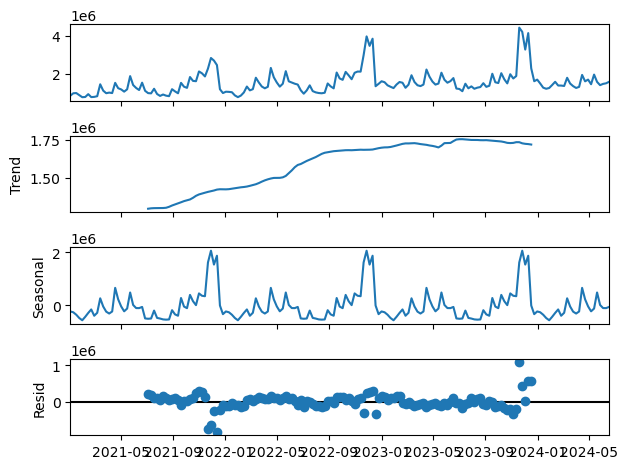

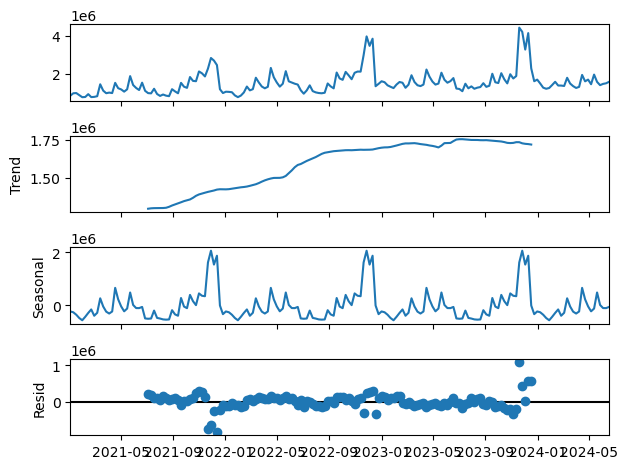

In [28]:
#Decomposition:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()




#### 2.3 Plot Autocorrelation:
Lags are on horizontal axis, correlations are on vertical axis

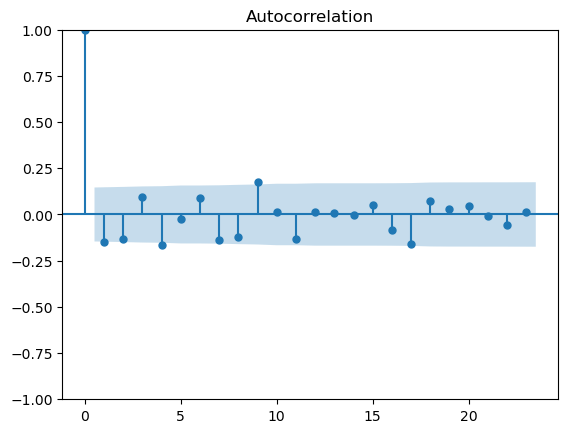

In [170]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Revenue"].diff()[1:])
%matplotlib inline

#### 2.3 Plot the data

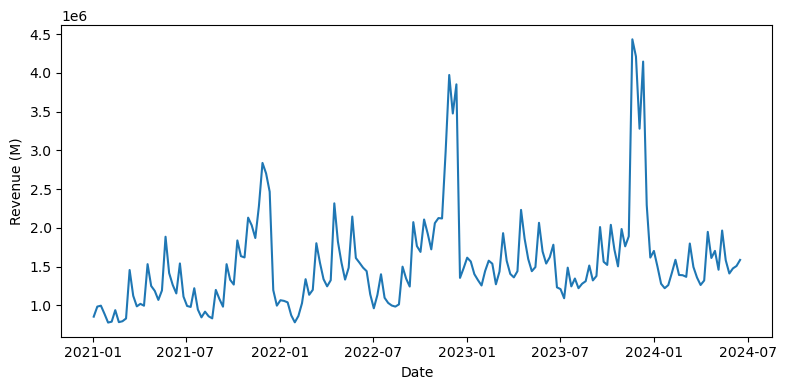

In [34]:
# Visualize data; y axis Revenue is in millions
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(df['Revenue'])
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (M)')
#fig.autofmt_xdate()
plt.tight_layout()

The plots show that the data clearly has very pronouced seasonality; for about half of the lags, the data is reasonably correlated to the previous version of itself. Either the Triple Exponential Smoothing, or the Error-Trend-Seasonality model seem to be the appropriate modeling option. 

In [37]:
# Check for Nulls
df.isnull().sum()

Revenue    0
dtype: int64

In [39]:
# If nulls are found, interpolate data points (fit the straight line in place of missing data points)
# df = df.interpolate()

#### 3. Explore Exponential Smoothing Models

Break the data into train and test; set n (the number of desired entries in test set). <br> Since the data shows clear signs of seasonality, select as the test set all of last year. Run a number of exponential smoothing forecasts and compare the results.<br>

To compare the results, define a function for MAPE (Mean Absolute Persentage Error).


In [42]:
# Set up index for the beginning of TEST set(cut off point between train and test)
test_index = '2023-10-01'

#Calculate the size of Test set
n = df[df.index >= test_index].shape[0]

n, n/df.shape[0]

(38, 0.20994475138121546)

In [44]:
# Define index for the last row - to be used later for the charts
end_index = str(df[-1:].index[0])
end_index

'2024-06-16 00:00:00'

In [46]:
df[0:].index[0]

Timestamp('2021-01-03 00:00:00')

In [48]:
# Break data on train and test sets based on index chosen above:
train = df[:-n]
test = df[-n:]

In [50]:
#train
print (f'Shape of Train set: {train.shape}')
print (f'Shape of Test set: {test.shape}')

Shape of Train set: (143, 1)
Shape of Test set: (38, 1)


In [52]:
test.index

DatetimeIndex(['2023-10-01', '2023-10-08', '2023-10-15', '2023-10-22',
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31', '2024-01-07', '2024-01-14',
               '2024-01-21', '2024-01-28', '2024-02-04', '2024-02-11',
               '2024-02-18', '2024-02-25', '2024-03-03', '2024-03-10',
               '2024-03-17', '2024-03-24', '2024-03-31', '2024-04-07',
               '2024-04-14', '2024-04-21', '2024-04-28', '2024-05-05',
               '2024-05-12', '2024-05-19', '2024-05-26', '2024-06-02',
               '2024-06-09', '2024-06-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [54]:
# Make copy of test to avoid SettingWithCopyWarning
test = test.copy()

In [56]:
# define function for estimation of Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/ y_true))* 100, 2)

#### 3.1 Simple Exponential Smoothing (SES) Model (flat forecast based on level / average)
Simple Exponential Smoothing uses Level of the series (average value) to create a forecast.  Thus, the forecast is simply a flat line.<br>
SES is a compromise between two naive methods: projecting the last known value to the future and taking an average of the whole series.<br>
Importance assigned to the last known vs historical values is defined by the smoothing factor alpha.  The closer alpha is to 1, the more important the last known value is.<br><br>
Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below:
$$ s_0 = x_0 \\ s_t = \alpha x_t + (1-\alpha) s_{t-1} = s_{t-1} \alpha(x_t - s_{t-1}),\ t \gt 0 $$

The greater the $alpha$, the more important is the last obervation as opposed to the previous one.

In [59]:
# Bypass out of date error (convergence warning - out of date error produced by statsmodels)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Ignore VaLueWarning - it may be given if no frequency is provided, and the model is defaulted to Weekly, Sunday (which is what is needed here)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)


In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [63]:
# fit the model on train set:
ses = SimpleExpSmoothing(train, initialization_method = 'estimated').fit()

In [65]:
print(f"alpha = {ses.model.params['smoothing_level']}")

alpha = 0.7762790697674419


In [67]:
#Make a forcast, passing a number or data points to be forecasted (In Sample)
ses_pred = ses.forecast(n)

In [69]:
# Add a SES_Prediction column to the test data frame
test.loc[:,'SES_Prediction'] = ses_pred
test.head()

,Revenue,SES_Prediction
Date,,
2023-10-01,1521177.82,1.630319e+06
2023-10-08,2038732.26,1.630319e+06
2023-10-15,1719146.04,1.630319e+06
2023-10-22,1502429.64,1.630319e+06
2023-10-29,1984600.34,1.630319e+06


As expected, the forecasted value (SES_Prediction) for simple exponential smoothing is a flat line.

In [72]:
# Evaluate the model: Mean absolute persentage error for SES

mape_ses = mape(test['Revenue'], test['SES_Prediction'])
print(f'SES MAPE: {mape_ses}%')

SES MAPE: 18.48%


#### 3.2 Exploring Double Exponential Smoothing (Holt's Method)<br>
The Double Exponential Smoothing algorithm (Holt's Method) adds to the smoothing equation a new parameter $beta$ to define the trend. It is a second order smoothing method using two coupled difference equations. A trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend: 
$$ s_t = \alpha x_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\ b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1} $$

In [75]:
from statsmodels.tsa.holtwinters import Holt

In [77]:
# fit Double Exp Smoothing models with and without damping factor
des1 = Holt(train['Revenue'], exponential = False, damped_trend=False, initialization_method ='estimated').fit()
des2 = Holt(train['Revenue'], exponential = False, damped_trend = True, initialization_method = 'estimated').fit()

In [79]:
# print parameters
print('Parameters for DES Model without damping')
print(f"alpha = {des1.model.params['smoothing_level']}")
print(f"beta = {des1.model.params['smoothing_trend']}")
print ('----------------------------------------------')
print('Parameters for DES Model with damping')
print(f"alpha = {des2.model.params['smoothing_level']}")
print(f"beta = {des2.model.params['smoothing_trend']}")

Parameters for DES Model without damping
alpha = 0.7828571428571428
beta = 0.0001
----------------------------------------------
Parameters for DES Model with damping
alpha = 0.7828571428571428
beta = 0.0001


For both models, Alpha is almost the same as in the SES model; Beta is tiny, as was expected since the data doesn't show steep bias.

In [82]:
# Create forecasts:
des1_pred = des1.forecast(n)
des2_pred = des2.forecast(n)

test.loc[:,['Des1_Prediction']] = des1_pred
test.loc[:,['Des2_Prediction']] = des2_pred


In [84]:
# Evaluate models:
#Calcuate MAPE for the model:
mape_des1 = mape(test['Revenue'], test['Des1_Prediction'])
mape_des2 = mape(test['Revenue'], test['Des2_Prediction'])

print(f'Des1 MAPE: {mape_des1}%')
print(f'Des2 MAPE: {mape_des2}%')

Des1 MAPE: 22.05%
Des2 MAPE: 17.06%


#### 3.3 Exploring Triple Exponential Smoothing (Holt-Winters Method)
Triple Exp Smoothing expands upon Double Exp Smoothing by adding a seasonality component.  Suitable for a series with trend and seasonality.  In our case, we have yearly seasonality (365) to adjust for. The maginitude of fluctuations remains about the same, so the seasonality here is additive (as opposed to multiplicative). The only exception is the last year, which displays a more multiplicative seasonality. We will try both. <br>

Seasonality is defined by the additional parameter $gamma$ (0 < gamma < 1)


In [87]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [89]:
tes = ExponentialSmoothing(
     train['Revenue'],
     trend = 'add',                          #linear trend
     seasonal = 'additive',                  # select type of seasonality: additive or multiplicative
     #seasonal = 'multiplicative',
     #seasonal_periods = 48,                 #Number of periods in season: in this case, 48 weeks in year
     #freq = 'W',                            # Frequency: W for week
     initialization_method = 'estimated').fit()  
              

In [91]:
#### Print parameters:
print(f"alpha = {tes.model.params['smoothing_level']}")
print(f"beta = {tes.model.params['smoothing_trend']}")
print(f"gamma = {tes.model.params['smoothing_seasonal']}")


alpha = 0.5707142857142857
beta = 0.0001
gamma = 0.22593984962406014


In [93]:
data.tail()

,Date,Revenue
177,5/26/2024,1410419.87
178,6/2/2024,1475902.79
179,6/9/2024,1507299.95
180,6/16/2024,1585605.19
181,6/23/2024,177249.60


In [95]:
# Made Prediction (In sample, for test):
tes_pred = tes.forecast(n)
test.loc[:,'TES_Prediction'] = tes_pred
test.head()

,Revenue,SES_Prediction,Des1_Prediction,Des2_Prediction,TES_Prediction
Date,,,,,
2023-10-01,1521177.82,1.630319e+06,1.610623e+06,1.624848e+06,1.555560e+06
2023-10-08,2038732.26,1.630319e+06,1.596060e+06,1.621466e+06,2.089001e+06
2023-10-15,1719146.04,1.630319e+06,1.581498e+06,1.618117e+06,1.904388e+06
2023-10-22,1502429.64,1.630319e+06,1.566935e+06,1.614801e+06,1.842806e+06
2023-10-29,1984600.34,1.630319e+06,1.552372e+06,1.611519e+06,2.336802e+06


In [97]:
#Evaluate Model:
mape_tes = mape(test['Revenue'], test['TES_Prediction'])
print(f'TES MAPE: {mape_tes}%')


TES MAPE: 17.66%


#### 3.4 Explore Error Trend and Seasonality Model - ETS
The ETS model is a generalization of simple exponential smoothing that contains trends and seasonalities. Additionally it has an underlying <b> State-Space </b> Model consisting of a Level component (L), a Trend component (T), a Seasonal component S), and and an Error term (E). <br>The State-space model contains two sets of equations: one describing how data is changing in time, the other how the observer is measuring in each period.  Thus, the model's output is a variable (vector), rather than a single value. <br>

One of the methods (.predicted_mean) allows us to retrieve the mean of the variable, as an actual prediction.  The other method (.pred_int) allows us to retrieve confidence intervals for the specified alpha.


In [100]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [102]:
# Fit the model:
ets = ETSModel(
       train['Revenue'],
       trend = 'add',                          #linear trend
       #damped_trend = 'True',
       #seasonal = 'additive',                 # select type of seasonality: additive or multiplicative
       seasonal = 'multiplicative',
       #seasonal_periods = 48,                 #Number of periods in season: in this case, 48 weeks in year
       #freq = 'W',                            # Frequency: W for week
       initialization_method = 'estimated').fit()           #optionally, try to fit with intitialization_method = 'heuristic'

In [104]:
# Make prediction in sample (for Test data) and add it to the data frame:
prediction = ets.get_prediction(start = test.index[0], end = test.index[-1]).predicted_mean
test.loc[:,'ETS_Prediction'] = prediction
test.head()

,Revenue,SES_Prediction,Des1_Prediction,Des2_Prediction,TES_Prediction,ETS_Prediction
Date,,,,,,
2023-10-01,1521177.82,1.630319e+06,1.610623e+06,1.624848e+06,1.555560e+06,1.497125e+06
2023-10-08,2038732.26,1.630319e+06,1.596060e+06,1.621466e+06,2.089001e+06,1.979552e+06
2023-10-15,1719146.04,1.630319e+06,1.581498e+06,1.618117e+06,1.904388e+06,1.790818e+06
2023-10-22,1502429.64,1.630319e+06,1.566935e+06,1.614801e+06,1.842806e+06,1.675649e+06
2023-10-29,1984600.34,1.630319e+06,1.552372e+06,1.611519e+06,2.336802e+06,2.102648e+06


In [106]:
# Confidence Interval for ETS prediction for Test df
#ets.get_prediction(start = test.index[0], end = test.index[-1]).pred_int(alpha = 0.05)

In [108]:
# Evaluate Model:
mape_ets = mape(test['Revenue'], test['ETS_Prediction'])
print(f'ETS MAPE: {mape_ets}%')


ETS MAPE: 12.68%


#### 4. Visualize the Results:<br>
Below are plots for Train and Test.  The results of Test are shown in the gray box.

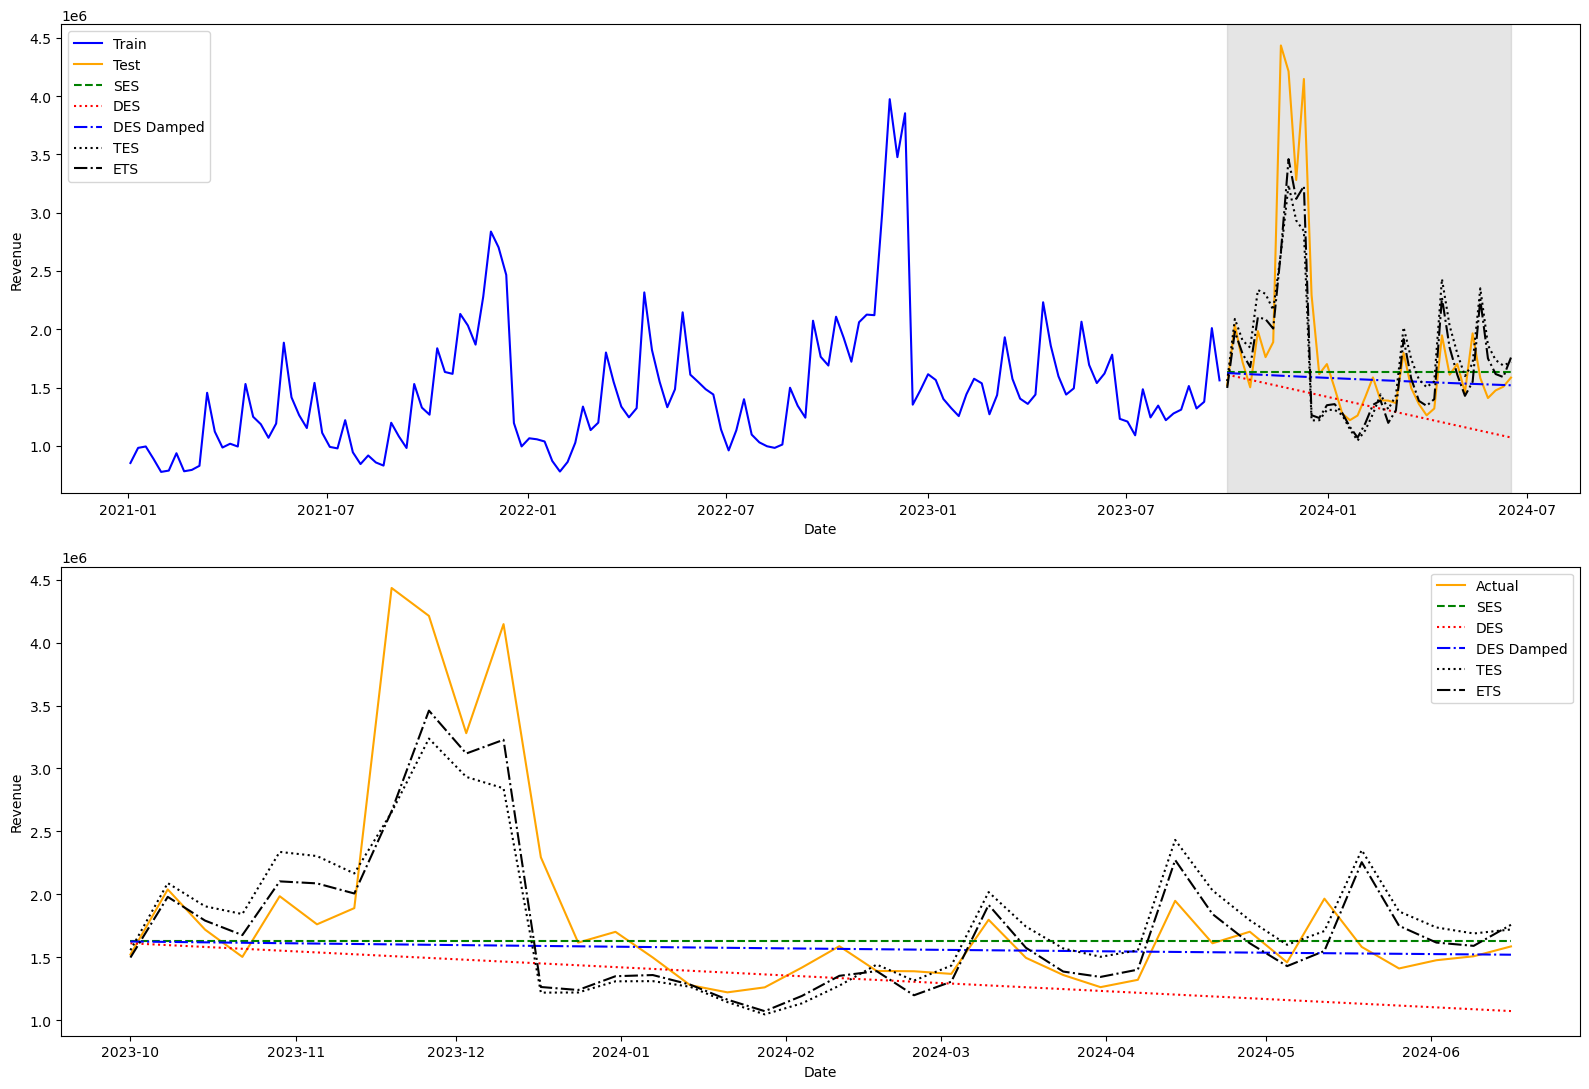

In [111]:
# Plot the forecast:
#Visualize train, test and baseline

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,11))

# Train and Test
ax1.plot(train['Revenue'], label = 'Train', color = 'blue')
ax1.plot(test['Revenue'], label = 'Test', color = 'orange')
#ax1.plot(test['Baseline_Prediction'], label = 'Baseline', color = 'pink', ls = '-')    # Base Prediction line
ax1.plot(test['SES_Prediction'],label = 'SES', color = 'green', ls= '--')              # SES Prediction line
ax1.plot(test['Des1_Prediction'], label = 'DES', color = 'red', ls = ':')              # DES1 Prediction line
ax1.plot(test['Des2_Prediction'], label = 'DES Damped', color = 'blue', ls = '-.')    # DES2 Prediction Line
ax1.plot(test['TES_Prediction'], label = 'TES', color = 'black', ls = ':')              # TES Prediction Line
ax1.plot(test['ETS_Prediction'], label = 'ETS', color = 'black', ls = '-.')              # ETS Prediction Line

ax1.legend( loc= 'best')
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue')
#fig.autofmt_xdate()

#ax1.axvspan (test_index,'2023-12-18', color = '#808080', alpha = 0.2)        # Change the date as needed
ax1.axvspan (test_index, end_index, color = '#808080', alpha = 0.2)        # beginning and end of test set are already defined
plt.tight_layout()

# zoomed in test set
ax2.plot(test['Revenue'], label = 'Actual', color = 'orange')
#ax2.plot(test['Baseline_Prediction'], label = 'Baseline', color ='pink', ls= '-')     #Base Prediction line
ax2.plot(test['SES_Prediction'],label = 'SES', color = 'green', ls= '--')             # SES Prediction line
ax2.plot(test['Des1_Prediction'], label = 'DES', color = 'red', ls = ':')             # DES1 Prediction line
ax2.plot(test['Des2_Prediction'], label = 'DES Damped', color = 'blue', ls = '-.')   # DES2 Prediction Line
ax2.plot(test['TES_Prediction'], label = 'TES', color = 'black', ls= ':')              # TES Prediction Line
ax2.plot(test['ETS_Prediction'], label = 'ETS', color = 'black', ls= '-.')              # ETS Prediction Line


ax2.legend(loc = 'best')
ax2.set_xlabel('Date')
ax2.set_ylabel('Revenue')

#fig.autofmt_xdate()
plt.tight_layout()

As we can see on the plot, the TES and ETS models are close competitors. For the most part, the ETS graph is closer to the actual data than that of TES. However, the graphs sometimes cross, and for some periods Triple Exponential Smoothing shows better performance.<br><br>
Next, I will compare Mean Absolute Percentage Error of the models and make predictions.

#### 5. Compare Models

In [115]:
# Compare models:
#print(f'Baseline Model MAPE: {mape_baseline}%')
print(f'Simple Exponential Smoothing MAPE: {mape_ses}%')
print(f'Double Exponential Smoothing MAPE: {mape_des1}%')
print(f'Double Exponential Smoothing with Damping factor MAPE: {mape_des2}%')
print(f'Triple Exponential Smoothing MAPE: {mape_tes}%')
print(f'Error Trend and Seasonality MAPE: {mape_ets}%')


Simple Exponential Smoothing MAPE: 18.48%
Double Exponential Smoothing MAPE: 22.05%
Double Exponential Smoothing with Damping factor MAPE: 17.06%
Triple Exponential Smoothing MAPE: 17.66%
Error Trend and Seasonality MAPE: 12.68%


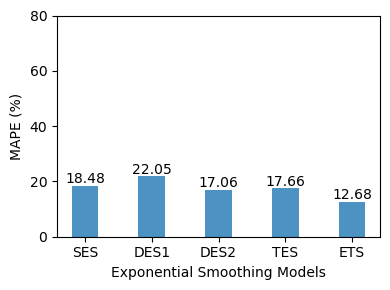

In [117]:
fig, ax = plt.subplots(figsize = (4,3), alpha = 0.4)
x = ['SES','DES1', 'DES2', 'TES', 'ETS']
y = [mape_ses, mape_des1, mape_des2, mape_tes, mape_ets]

ax.bar(x,y,width =0.4, alpha = 0.8)
ax.set_xlabel('Exponential Smoothing Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,80)

for index, value in enumerate(y):
    plt.text(x = index, y = value + 0.8, s = str(value), ha = 'center')
    
plt.tight_layout()

The ETS model has the lowest MAPE of 12.68%.  Triple Exponential Smoothing and Double Exponential Smoothing with damping have somewhat higher error rates, 17.66% and 17.06% respectively.  Since the data is clearly very seasonal, I won't be considering the Double Exponential Smoothing model. As for TES, it was shown above that it actually does make better predictions for some time periods, so I will consider adding it to the predictions data frame.

#### 5. Predict out of test data with Error Trend and Seasonality Model (ETS) and calculate Confidence Intervals (CI)
Predictions are made by using the .get_prediction method on fitted ETS model.<br>
Prediction mean is retrieved with the .predicted_mean method.<br>
Confidence intervals are added with the .pred_int method. <br>
A quick way to get a prediction summary is to use .summary_frame on the prediction object<br><br>
Note that .pred_int and summary_frame assume that we start from the the first data point after the Train set.  Thus, this date is the only one which can be specified as 'start'. Thus, the data set for prediction will have to originally include the Test data as well. Later, the Test part will be removed from the prediction table.<br><br>

##### Prepare the data:

In [121]:
test_index_start = str(test.index[0].date())
test_index_start

'2023-10-01'

In [123]:
test_index_end = str(test.index[-1].date())
test_index_end

'2024-06-16'

In [125]:
train_index_end = str(train.index[-1].date())
train_index_end

'2023-09-24'

In [127]:

# for Predicting from 06/24/2024 through the end of the year 
index  = pd.date_range(test_index_start, periods = 122, freq = 'W')   # use if data is aggregated for beginning of the week

df_pred = pd.DataFrame(index = index)
df_pred = df_pred.fillna(0)

In [129]:
df_pred.index[0], df_pred.index[-1]

(Timestamp('2023-10-01 00:00:00'), Timestamp('2026-01-25 00:00:00'))

In [131]:
# Define start and end of out of sample prediction time frame
prediction_start = '2024-06-23'                           # choose the start for out of sample prediction; chop off test data

prediction_end = str(df_pred.index[-1])                   # end is defined by the number of chosen periods

prediction_start, prediction_end

('2024-06-23', '2026-01-25 00:00:00')

##### Make prediction with ETS model:
NOTE: start always has to be the first index of the Test (next one after last in Train)

In [134]:
# Quick way to get prediction summary for 2024: use .summary_frame

prediction = ets.get_prediction(start = df_pred.index[0], end = df_pred.index[-1])

prediction_df = prediction.summary_frame(alpha = 0.2)
prediction_df = prediction_df[prediction_df.index >= prediction_start]   # truncated df to start from week (end of week) of prediction
prediction_df.drop(['mean_numerical'], axis = 1, inplace = True)
prediction_df = prediction_df.astype(int)
prediction_df.head()

,mean,pi_lower,pi_upper
2024-06-23,1282930,557853,1897536
2024-06-30,1169547,485453,1750275
2024-07-07,1176649,489846,1768235
2024-07-14,1511501,621447,2293624
2024-07-21,1215258,482377,1869831


In [136]:
prediction_df.tail()

,mean,pi_lower,pi_upper
2025-12-28,1616135,268601,2939497
2026-01-04,1626834,243554,2979029
2026-01-11,1535388,207556,2807645
2026-01-18,1391802,207037,2533769
2026-01-25,1281664,180271,2313976


##### Chart the Actual data and Prediction for the next year

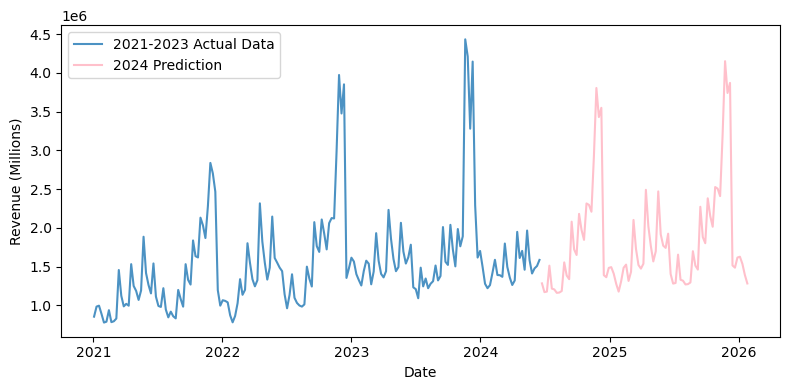

In [139]:
# ETS chart
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(df['Revenue'], label = '2021-2023 Actual Data', alpha = 0.8)
#ax.plot(df_pred['Prediction'], color = 'pink', label = '2024 Prediction')   # use for TES Prediction
ax.plot(prediction_df['mean'], color = 'pink', label = '2024 Prediction')    # use for ETS Prediction
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (Millions)')
ax.legend(loc = 'best')
#fig.autofmt_xdate()
plt.tight_layout()

In [142]:
prediction_df.shape

(84, 3)

In [144]:
prediction_df.rename(columns = {'mean':'ETS Prediction','pi_lower': 'ETS Lower CI', 'pi_upper': 'ETS Upper CI'}, inplace = True)

In [146]:
prediction_df.head()

,ETS Prediction,ETS Lower CI,ETS Upper CI
2024-06-23,1282930,557853,1897536
2024-06-30,1169547,485453,1750275
2024-07-07,1176649,489846,1768235
2024-07-14,1511501,621447,2293624
2024-07-21,1215258,482377,1869831


In [148]:
prediction_df.tail()

,ETS Prediction,ETS Lower CI,ETS Upper CI
2025-12-28,1616135,268601,2939497
2026-01-04,1626834,243554,2979029
2026-01-11,1535388,207556,2807645
2026-01-18,1391802,207037,2533769
2026-01-25,1281664,180271,2313976


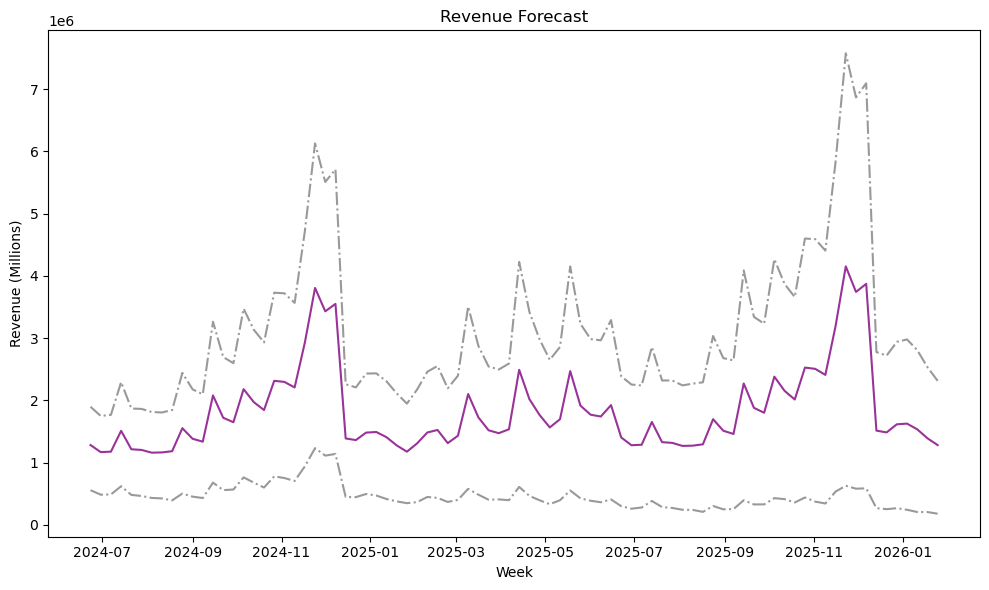

In [150]:
# Visualize Monthly Prediction for 2024:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(prediction_df['ETS Prediction'], label = 'Prediction', color = 'purple', alpha = 0.8)
ax.plot(prediction_df['ETS Lower CI'], label = 'Lower CI', color = 'gray', ls = '-.', alpha = 0.8)
ax.plot(prediction_df['ETS Upper CI'], label = 'Upper CI', color = 'gray', ls = '-.', alpha = 0.8)
ax.set_xlabel('Week')
ax.set_ylabel('Revenue (Millions)')
ax.set_title('Revenue Forecast')

#for index, value in enumerate(df_2024['Revenue']):
    #plt.text(x = index, y = value + 0.3, s = value, ha = 'center')
    
#fig.autofmt_xdate()
plt.tight_layout()

#####  Predict out of test data with the Triple Exponential Smoothing (TES) model; add prediction to the Prediction data frame.

In [153]:
prediction = tes.predict(start = prediction_start, end = prediction_end).astype(int)
prediction_df['TES Prediction'] = prediction

In [155]:
prediction_df.head()

,ETS Prediction,ETS Lower CI,ETS Upper CI,TES Prediction
2024-06-23,1282930,557853,1897536,1292474
2024-06-30,1169547,485453,1750275,1309650
2024-07-07,1176649,489846,1768235,1357701
2024-07-14,1511501,621447,2293624,1672110
2024-07-21,1215258,482377,1869831,1395237


In [157]:
prediction_df.tail()

,ETS Prediction,ETS Lower CI,ETS Upper CI,TES Prediction
2025-12-28,1616135,268601,2939497,1579017
2026-01-04,1626834,243554,2979029,1580440
2026-01-11,1535388,207556,2807645,1535857
2026-01-18,1391802,207037,2533769,1413752
2026-01-25,1281664,180271,2313976,1316102


##### Conclusion:
Based on the overall comparison of MAPE, the most accurate model was the state-space based Error-Trend-Seasonality with MAPE of 12.68%. However, as can be seen on the plots, for some months the graph of Triple Exponential Smoothing - the second best model - was a bit closer to the actual data than that of ETS. Thus, the data frame presented for the client included predictions by both ETS and TES models with graphs showing the time periods when the models are most accurate. <br><br>
Finally, note that some weeks in the data set (beginning and end) are not full so including them could result in a biased model; to avoid it, I only used data with full weeks. <br> <br>

